In [122]:
import requests
import random
import time
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import Optional, List
import json
from collections import defaultdict
import statistics

# Configuration
OMS_BASE_URL = "http://localhost:8090"
QUERY_API = f"{OMS_BASE_URL}/api/query/search"

In [123]:
# Stock symbols for queries
NASDAQ_SYMBOLS = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "INTC", "AMD", "NFLX", "PYPL", "ADBE", "CSCO", "QCOM", "COST"]
NYSE_SYMBOLS = ["JPM", "V", "JNJ", "WMT", "PG", "MA", "HD", "BAC", "DIS", "KO", "PFE", "XOM", "CVX", "NKE", "MCD"]
ALL_SYMBOLS = NASDAQ_SYMBOLS + NYSE_SYMBOLS

SIDES = ["BUY", "SELL"]
STATES = ["NEW", "LIVE", "FILLED", "CXL", "REJ"]

print(f"Loaded {len(ALL_SYMBOLS)} symbols for query testing")

Loaded 30 symbols for query testing


In [124]:
@dataclass
class QueryResult:
    """Result of a single query execution"""
    query_type: str
    params: dict
    success: bool
    status_code: int
    latency_ms: float
    result_count: int
    error: Optional[str] = None

def execute_query(params: dict, query_type: str = "custom") -> QueryResult:
    """Execute a query and measure latency"""
    start = time.perf_counter()
    
    try:
        response = requests.get(
            QUERY_API,
            params=params,
            headers={"Content-Type": "application/json"},
            timeout=30
        )
        latency_ms = (time.perf_counter() - start) * 1000
        
        result_count = 0
        if response.status_code == 200:
            data = response.json()
            # Handle paginated response
            if isinstance(data, dict) and "content" in data:
                result_count = len(data["content"])
            elif isinstance(data, list):
                result_count = len(data)
        
        return QueryResult(
            query_type=query_type,
            params=params,
            success=response.status_code == 200,
            status_code=response.status_code,
            latency_ms=latency_ms,
            result_count=result_count
        )
    except Exception as e:
        latency_ms = (time.perf_counter() - start) * 1000
        return QueryResult(
            query_type=query_type,
            params=params,
            success=False,
            status_code=0,
            latency_ms=latency_ms,
            result_count=0,
            error=str(e)
        )

In [125]:
# Query pattern generators
# NOTE: ReadySet can only cache queries with equality filters (=)
#       BETWEEN, range queries, and complex expressions are NOT cacheable

def query_by_symbol(symbol: Optional[str] = None) -> dict:
    """Query orders by symbol - CACHEABLE by ReadySet"""
    return {"symbol": symbol or random.choice(ALL_SYMBOLS)}

def query_by_side(side: Optional[str] = None) -> dict:
    """Query orders by side (BUY/SELL) - CACHEABLE by ReadySet"""
    return {"side": side or random.choice(SIDES)}

def query_by_symbol_and_side(symbol: Optional[str] = None, side: Optional[str] = None) -> dict:
    """Query orders by symbol AND side - CACHEABLE by ReadySet"""
    return {
        "symbol": symbol or random.choice(ALL_SYMBOLS),
        "side": side or random.choice(SIDES)
    }

def query_by_state(state: Optional[str] = None) -> dict:
    """Query orders by state - CACHEABLE by ReadySet"""
    return {"state": state or random.choice(STATES)}

def query_by_symbol_and_state(symbol: Optional[str] = None, state: Optional[str] = None) -> dict:
    """Query orders by symbol AND state - CACHEABLE by ReadySet"""
    return {
        "symbol": symbol or random.choice(ALL_SYMBOLS),
        "state": state or random.choice(STATES)
    }

def query_by_account(account: Optional[str] = None) -> dict:
    """Query orders by account - CACHEABLE by ReadySet"""
    accounts = [f"account-{i:02d}" for i in range(1, 11)]
    return {"account": account or random.choice(accounts)}

# NOT CACHEABLE - these use BETWEEN which ReadySet doesn't support
def query_by_price_range(min_price: float = 20, max_price: float = 100) -> dict:
    """Query orders within a price range - NOT CACHEABLE (uses BETWEEN)"""
    return {"price__between": f"{min_price},{max_price}"}

def query_paginated(page: int = 0, size: int = 20, sort: str = "transactTime,desc") -> dict:
    """Paginated query with sorting"""
    return {"page": page, "size": size, "sort": sort}

def query_combined_cacheable() -> dict:
    """Random combined query using ONLY cache-friendly filters"""
    params = {}
    
    # Only use equality filters (no BETWEEN, no ranges)
    if random.random() > 0.2:
        params["symbol"] = random.choice(ALL_SYMBOLS)
    if random.random() > 0.4:
        params["side"] = random.choice(SIDES)
    if random.random() > 0.6:
        params["state"] = random.choice(STATES)
    
    # Always add pagination
    params["page"] = 0
    params["size"] = random.choice([10, 20, 50])
    
    return params if len(params) > 2 else query_by_symbol()

# Legacy function for comparison - NOT CACHEABLE
def query_combined() -> dict:
    """Random combined query - may include non-cacheable BETWEEN filters"""
    params = {}
    if random.random() > 0.3:
        params["symbol"] = random.choice(ALL_SYMBOLS)
    if random.random() > 0.5:
        params["side"] = random.choice(SIDES)
    if random.random() > 0.7:
        min_p = random.randint(20, 100)
        max_p = min_p + random.randint(50, 200)
        params["price__between"] = f"{min_p},{max_p}"  # NOT CACHEABLE!
    params["page"] = 0
    params["size"] = random.choice([10, 20, 50, 100])
    return params if len(params) > 2 else query_by_symbol()

# Test a query
result = execute_query(query_by_symbol("INTC"), "symbol_lookup")
print(f"Query: symbol=INTC")
print(f"Success: {result.success}")
print(f"Latency: {result.latency_ms:.2f} ms")
print(f"Results: {result.result_count} orders")
print(f"\n⚠️  ReadySet Cache Notes:")
print(f"   ✓ Cacheable: symbol=, side=, state=, account= (equality filters)")
print(f"   ✗ NOT Cacheable: price__between, orderQty__between, date ranges")

Query: symbol=INTC
Success: True
Latency: 12.84 ms
Results: 50 orders

⚠️  ReadySet Cache Notes:
   ✓ Cacheable: symbol=, side=, state=, account= (equality filters)
   ✗ NOT Cacheable: price__between, orderQty__between, date ranges


In [126]:
def run_query_batch(
    query_generator,
    count: int = 100,
    delay_ms: int = 50,
    query_type: str = "batch",
    verbose: bool = True
) -> List[QueryResult]:
    """Run a batch of queries using the specified generator"""
    results = []
    latencies = []
    
    print(f"\n{'='*70}")
    print(f" Running {count} queries - Type: {query_type}")
    print(f"{'='*70}\n")
    
    start_time = time.time()
    
    for i in range(count):
        params = query_generator()
        result = execute_query(params, query_type)
        results.append(result)
        
        if result.success:
            latencies.append(result.latency_ms)
            if verbose and (i + 1) % 10 == 0:
                print(f"[{i+1:4d}/{count}] Avg latency: {statistics.mean(latencies[-10:]):.2f} ms")
        else:
            if verbose:
                print(f"[{i+1:4d}/{count}] ✗ {result.error or 'Failed'}")
        
        if delay_ms > 0 and i < count - 1:
            time.sleep(delay_ms / 1000)
    
    elapsed = time.time() - start_time
    success_count = sum(1 for r in results if r.success)
    
    print(f"\n{'='*70}")
    print(f" Results Summary")
    print(f"{'='*70}")
    print(f" Queries:    {success_count}/{count} successful")
    print(f" Total time: {elapsed:.2f}s ({count/elapsed:.1f} queries/sec)")
    
    if latencies:
        print(f"\n Latency Statistics:")
        print(f"   Min:    {min(latencies):.2f} ms")
        print(f"   Max:    {max(latencies):.2f} ms")
        print(f"   Mean:   {statistics.mean(latencies):.2f} ms")
        print(f"   Median: {statistics.median(latencies):.2f} ms")
        if len(latencies) >= 2:
            print(f"   StdDev: {statistics.stdev(latencies):.2f} ms")
        # P95 and P99
        sorted_lat = sorted(latencies)
        p95_idx = int(len(sorted_lat) * 0.95)
        p99_idx = int(len(sorted_lat) * 0.99)
        print(f"   P95:    {sorted_lat[p95_idx]:.2f} ms")
        print(f"   P99:    {sorted_lat[p99_idx]:.2f} ms")
    
    print(f"{'='*70}\n")
    
    return results

## Query Pattern Tests

Run these cells to test different query patterns. 

**Tip:** Run the metrics collector in a terminal first:
```powershell
python readyset-timeseries.py --duration 120
```

### ReadySet Cache Compatibility
| Query Type | Cacheable | Reason |
|------------|-----------|--------|
| `symbol=X` | ✓ Yes | Equality filter |
| `side=BUY` | ✓ Yes | Equality filter |
| `state=LIVE` | ✓ Yes | Equality filter |
| `symbol=X&side=BUY` | ✓ Yes | Combined equality |
| `price__between=X,Y` | ✗ No | BETWEEN not supported |
| `orderQty__between=X,Y` | ✗ No | BETWEEN not supported |

In [127]:
# Test 1: Repeated symbol lookups (should cache well)
# Same query pattern = high cache hit rate expected

def same_symbol_query():
    return query_by_symbol("INTC")

results_same = run_query_batch(same_symbol_query, count=50, delay_ms=20, query_type="same_symbol")


 Running 50 queries - Type: same_symbol

[  10/50] Avg latency: 20.25 ms
[  10/50] Avg latency: 20.25 ms
[  20/50] Avg latency: 16.56 ms
[  20/50] Avg latency: 16.56 ms
[  30/50] Avg latency: 19.02 ms
[  30/50] Avg latency: 19.02 ms
[  40/50] Avg latency: 17.51 ms
[  40/50] Avg latency: 17.51 ms
[  50/50] Avg latency: 16.42 ms

 Results Summary
 Queries:    50/50 successful
 Total time: 1.93s (26.0 queries/sec)

 Latency Statistics:
   Min:    9.90 ms
   Max:    53.26 ms
   Mean:   17.95 ms
   Median: 12.19 ms
   StdDev: 9.08 ms
   P95:    33.66 ms
   P99:    53.26 ms

[  50/50] Avg latency: 16.42 ms

 Results Summary
 Queries:    50/50 successful
 Total time: 1.93s (26.0 queries/sec)

 Latency Statistics:
   Min:    9.90 ms
   Max:    53.26 ms
   Mean:   17.95 ms
   Median: 12.19 ms
   StdDev: 9.08 ms
   P95:    33.66 ms
   P99:    53.26 ms



In [128]:
# Test 2: Random symbol lookups (tests cache across different symbols)
results_random = run_query_batch(query_by_symbol, count=100, delay_ms=20, query_type="random_symbol")


 Running 100 queries - Type: random_symbol

[  10/100] Avg latency: 16.65 ms
[  10/100] Avg latency: 16.65 ms
[  20/100] Avg latency: 12.01 ms
[  20/100] Avg latency: 12.01 ms
[  30/100] Avg latency: 15.75 ms
[  30/100] Avg latency: 15.75 ms
[  40/100] Avg latency: 16.39 ms
[  40/100] Avg latency: 16.39 ms
[  50/100] Avg latency: 15.00 ms
[  50/100] Avg latency: 15.00 ms
[  60/100] Avg latency: 17.72 ms
[  60/100] Avg latency: 17.72 ms
[  70/100] Avg latency: 16.10 ms
[  70/100] Avg latency: 16.10 ms
[  80/100] Avg latency: 14.88 ms
[  80/100] Avg latency: 14.88 ms
[  90/100] Avg latency: 12.98 ms
[  90/100] Avg latency: 12.98 ms
[ 100/100] Avg latency: 16.24 ms

 Results Summary
 Queries:    100/100 successful
 Total time: 3.61s (27.7 queries/sec)

 Latency Statistics:
   Min:    8.60 ms
   Max:    30.93 ms
   Mean:   15.37 ms
   Median: 10.59 ms
   StdDev: 7.58 ms
   P95:    27.86 ms
   P99:    30.93 ms

[ 100/100] Avg latency: 16.24 ms

 Results Summary
 Queries:    100/100 success

In [129]:
# Test 3: Symbol + Side combination (more specific queries)
results_combo = run_query_batch(query_by_symbol_and_side, count=100, delay_ms=20, query_type="symbol_and_side")


 Running 100 queries - Type: symbol_and_side

[  10/100] Avg latency: 13.06 ms
[  10/100] Avg latency: 13.06 ms
[  20/100] Avg latency: 15.89 ms
[  20/100] Avg latency: 15.89 ms
[  30/100] Avg latency: 21.32 ms
[  30/100] Avg latency: 21.32 ms
[  40/100] Avg latency: 14.67 ms
[  40/100] Avg latency: 14.67 ms
[  50/100] Avg latency: 21.50 ms
[  50/100] Avg latency: 21.50 ms
[  60/100] Avg latency: 13.15 ms
[  60/100] Avg latency: 13.15 ms
[  70/100] Avg latency: 19.75 ms
[  70/100] Avg latency: 19.75 ms
[  80/100] Avg latency: 15.02 ms
[  80/100] Avg latency: 15.02 ms
[  90/100] Avg latency: 12.91 ms
[  90/100] Avg latency: 12.91 ms
[ 100/100] Avg latency: 20.28 ms

 Results Summary
 Queries:    100/100 successful
 Total time: 3.73s (26.8 queries/sec)

 Latency Statistics:
   Min:    8.02 ms
   Max:    36.34 ms
   Mean:   16.76 ms
   Median: 10.32 ms
   StdDev: 8.85 ms
   P95:    30.90 ms
   P99:    36.34 ms

[ 100/100] Avg latency: 20.28 ms

 Results Summary
 Queries:    100/100 succe

In [130]:
# Test 4: State queries (CACHEABLE)
results_state = run_query_batch(query_by_state, count=50, delay_ms=20, query_type="by_state")


 Running 50 queries - Type: by_state

[  10/50] Avg latency: 18.44 ms
[  10/50] Avg latency: 18.44 ms
[  20/50] Avg latency: 13.88 ms
[  20/50] Avg latency: 13.88 ms
[  30/50] Avg latency: 14.87 ms
[  30/50] Avg latency: 14.87 ms
[  40/50] Avg latency: 19.47 ms
[  40/50] Avg latency: 19.47 ms
[  50/50] Avg latency: 14.79 ms

 Results Summary
 Queries:    50/50 successful
 Total time: 1.82s (27.5 queries/sec)

 Latency Statistics:
   Min:    7.60 ms
   Max:    34.31 ms
   Mean:   16.29 ms
   Median: 9.38 ms
   StdDev: 9.32 ms
   P95:    30.84 ms
   P99:    34.31 ms

[  50/50] Avg latency: 14.79 ms

 Results Summary
 Queries:    50/50 successful
 Total time: 1.82s (27.5 queries/sec)

 Latency Statistics:
   Min:    7.60 ms
   Max:    34.31 ms
   Mean:   16.29 ms
   Median: 9.38 ms
   StdDev: 9.32 ms
   P95:    30.84 ms
   P99:    34.31 ms



In [131]:
# Test 5: Paginated queries with sorting
results_paginated = run_query_batch(query_paginated, count=50, delay_ms=30, query_type="paginated")


 Running 50 queries - Type: paginated

[  10/50] Avg latency: 18.95 ms
[  10/50] Avg latency: 18.95 ms
[  20/50] Avg latency: 21.22 ms
[  20/50] Avg latency: 21.22 ms
[  30/50] Avg latency: 20.77 ms
[  30/50] Avg latency: 20.77 ms
[  40/50] Avg latency: 19.81 ms
[  40/50] Avg latency: 19.81 ms
[  50/50] Avg latency: 17.69 ms

 Results Summary
 Queries:    50/50 successful
 Total time: 2.49s (20.1 queries/sec)

 Latency Statistics:
   Min:    10.77 ms
   Max:    36.74 ms
   Mean:   19.69 ms
   Median: 13.65 ms
   StdDev: 8.94 ms
   P95:    34.26 ms
   P99:    36.74 ms

[  50/50] Avg latency: 17.69 ms

 Results Summary
 Queries:    50/50 successful
 Total time: 2.49s (20.1 queries/sec)

 Latency Statistics:
   Min:    10.77 ms
   Max:    36.74 ms
   Mean:   19.69 ms
   Median: 13.65 ms
   StdDev: 8.94 ms
   P95:    34.26 ms
   P99:    36.74 ms



In [132]:
# Test 6: Mixed CACHEABLE queries (realistic workload with good cache hit rate)
results_combined = run_query_batch(query_combined_cacheable, count=200, delay_ms=10, query_type="mixed_cacheable")


 Running 200 queries - Type: mixed_cacheable

[  10/200] Avg latency: 17.46 ms
[  10/200] Avg latency: 17.46 ms
[  20/200] Avg latency: 11.60 ms
[  20/200] Avg latency: 11.60 ms
[  30/200] Avg latency: 13.31 ms
[  30/200] Avg latency: 13.31 ms
[  40/200] Avg latency: 16.31 ms
[  40/200] Avg latency: 16.31 ms
[  50/200] Avg latency: 14.47 ms
[  50/200] Avg latency: 14.47 ms
[  60/200] Avg latency: 14.04 ms
[  60/200] Avg latency: 14.04 ms
[  70/200] Avg latency: 19.83 ms
[  70/200] Avg latency: 19.83 ms
[  80/200] Avg latency: 15.20 ms
[  80/200] Avg latency: 15.20 ms
[  90/200] Avg latency: 15.93 ms
[  90/200] Avg latency: 15.93 ms
[ 100/200] Avg latency: 20.28 ms
[ 100/200] Avg latency: 20.28 ms
[ 110/200] Avg latency: 17.30 ms
[ 110/200] Avg latency: 17.30 ms
[ 120/200] Avg latency: 19.42 ms
[ 120/200] Avg latency: 19.42 ms
[ 130/200] Avg latency: 12.20 ms
[ 130/200] Avg latency: 12.20 ms
[ 140/200] Avg latency: 11.45 ms
[ 140/200] Avg latency: 11.45 ms
[ 150/200] Avg latency: 13.38

## Heavy Load Test (Cache-Friendly)

Generate sustained query load using only cacheable query patterns.

In [133]:
# Heavy load: 500 CACHEABLE queries with minimal delay
results_heavy = run_query_batch(
    query_combined_cacheable, 
    count=500, 
    delay_ms=5, 
    query_type="heavy_cacheable",
    verbose=False
)


 Running 500 queries - Type: heavy_cacheable


 Results Summary
 Queries:    500/500 successful
 Total time: 11.02s (45.4 queries/sec)

 Latency Statistics:
   Min:    7.50 ms
   Max:    49.90 ms
   Mean:   16.36 ms
   Median: 11.61 ms
   StdDev: 7.71 ms
   P95:    27.79 ms
   P99:    34.76 ms


 Results Summary
 Queries:    500/500 successful
 Total time: 11.02s (45.4 queries/sec)

 Latency Statistics:
   Min:    7.50 ms
   Max:    49.90 ms
   Mean:   16.36 ms
   Median: 11.61 ms
   StdDev: 7.71 ms
   P95:    27.79 ms
   P99:    34.76 ms



## Non-Cacheable Query Test (for comparison)

Run this to see the difference between cacheable and non-cacheable queries.

In [134]:
# Compare: Run non-cacheable queries (uses BETWEEN - will bypass cache)
def query_non_cacheable():
    """Generates queries that ReadySet CANNOT cache"""
    min_p = random.randint(20, 100)
    max_p = min_p + random.randint(50, 200)
    return {"price__between": f"{min_p},{max_p}"}

results_non_cacheable = run_query_batch(
    query_non_cacheable, 
    count=100, 
    delay_ms=10, 
    query_type="non_cacheable_between",
    verbose=False
)

# Compare with cacheable
print("\n📊 Cache vs No-Cache Comparison:")
if 'results_combined' in dir() and results_combined:
    cacheable_latencies = [r.latency_ms for r in results_combined if r.success]
    noncache_latencies = [r.latency_ms for r in results_non_cacheable if r.success]
    
    if cacheable_latencies and noncache_latencies:
        print(f"   Cacheable queries:     avg {statistics.mean(cacheable_latencies):.2f} ms")
        print(f"   Non-cacheable queries: avg {statistics.mean(noncache_latencies):.2f} ms")


 Running 100 queries - Type: non_cacheable_between


 Results Summary
 Queries:    100/100 successful
 Total time: 3.10s (32.3 queries/sec)

 Latency Statistics:
   Min:    10.95 ms
   Max:    37.11 ms
   Mean:   19.95 ms
   Median: 13.12 ms
   StdDev: 9.76 ms
   P95:    35.70 ms
   P99:    37.11 ms


📊 Cache vs No-Cache Comparison:
   Cacheable queries:     avg 15.31 ms
   Non-cacheable queries: avg 19.95 ms

 Results Summary
 Queries:    100/100 successful
 Total time: 3.10s (32.3 queries/sec)

 Latency Statistics:
   Min:    10.95 ms
   Max:    37.11 ms
   Mean:   19.95 ms
   Median: 13.12 ms
   StdDev: 9.76 ms
   P95:    35.70 ms
   P99:    37.11 ms


📊 Cache vs No-Cache Comparison:
   Cacheable queries:     avg 15.31 ms
   Non-cacheable queries: avg 19.95 ms


## Compare Query Types

In [135]:
# Aggregate results by query type
all_results = {
    "Same Symbol (INTC)": results_same if 'results_same' in dir() else [],
    "Random Symbol": results_random if 'results_random' in dir() else [],
    "Symbol + Side": results_combo if 'results_combo' in dir() else [],
    "By State": results_state if 'results_state' in dir() else [],
    "Paginated": results_paginated if 'results_paginated' in dir() else [],
    "Mixed Cacheable": results_combined if 'results_combined' in dir() else [],
}

print(f"\n{'='*80}")
print(f" Query Type Comparison (Cache-Friendly Queries)")
print(f"{'='*80}")
print(f"{'Query Type':<25} {'Count':>8} {'Success':>8} {'Avg (ms)':>10} {'P95 (ms)':>10}")
print(f"{'-'*80}")

for query_type, results in all_results.items():
    if not results:
        continue
    
    success = sum(1 for r in results if r.success)
    latencies = [r.latency_ms for r in results if r.success]
    
    if latencies:
        avg = statistics.mean(latencies)
        sorted_lat = sorted(latencies)
        p95 = sorted_lat[int(len(sorted_lat) * 0.95)]
        print(f"{query_type:<25} {len(results):>8} {success:>8} {avg:>10.2f} {p95:>10.2f}")

print(f"{'='*80}\n")


 Query Type Comparison (Cache-Friendly Queries)
Query Type                   Count  Success   Avg (ms)   P95 (ms)
--------------------------------------------------------------------------------
Same Symbol (INTC)              50       50      17.95      33.66
Random Symbol                  100      100      15.37      27.86
Symbol + Side                  100      100      16.76      30.90
By State                        50       50      16.29      30.84
Paginated                       50       50      19.69      34.26
Mixed Cacheable                200      200      15.31      31.86



## Latency Visualization

C:\Users\tbade\AppData\Local\Temp\ipykernel_34020\3980198478.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(plot_data.values(), labels=plot_data.keys())


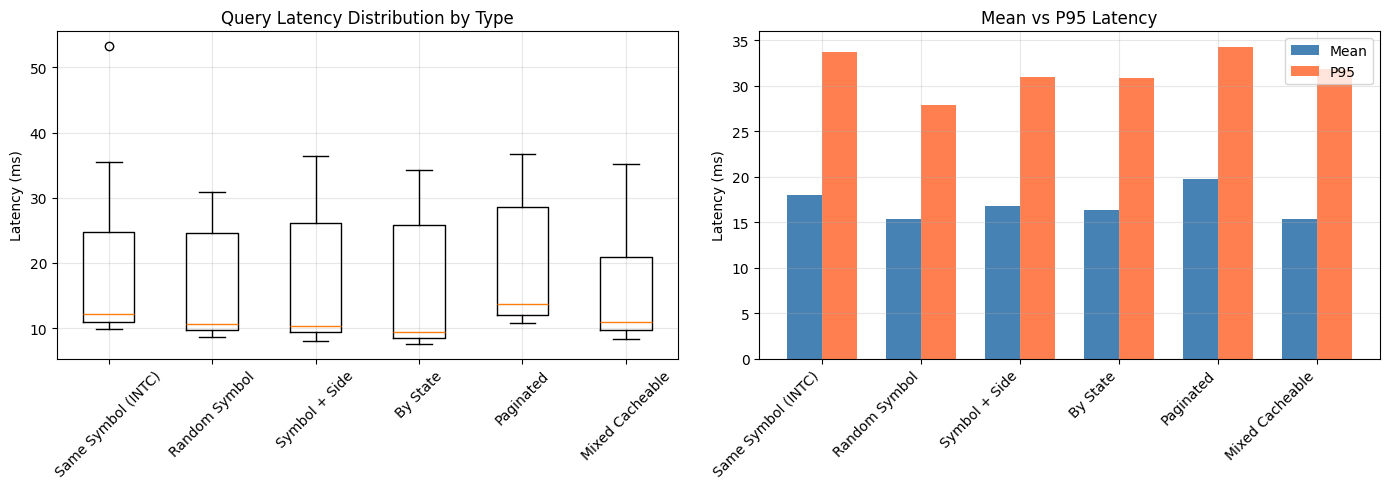


📈 Chart saved to query-latency-comparison.png


In [136]:
try:
    import matplotlib.pyplot as plt
    
    # Collect latencies for visualization
    plot_data = {}
    for query_type, results in all_results.items():
        latencies = [r.latency_ms for r in results if r.success]
        if latencies:
            plot_data[query_type] = latencies
    
    if plot_data:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Box plot
        ax1 = axes[0]
        ax1.boxplot(plot_data.values(), labels=plot_data.keys())
        ax1.set_ylabel('Latency (ms)')
        ax1.set_title('Query Latency Distribution by Type')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # Bar chart of averages
        ax2 = axes[1]
        names = list(plot_data.keys())
        avgs = [statistics.mean(v) for v in plot_data.values()]
        p95s = [sorted(v)[int(len(v)*0.95)] for v in plot_data.values()]
        
        x = range(len(names))
        width = 0.35
        ax2.bar([i - width/2 for i in x], avgs, width, label='Mean', color='steelblue')
        ax2.bar([i + width/2 for i in x], p95s, width, label='P95', color='coral')
        ax2.set_ylabel('Latency (ms)')
        ax2.set_title('Mean vs P95 Latency')
        ax2.set_xticks(x)
        ax2.set_xticklabels(names, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('query-latency-comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n📈 Chart saved to query-latency-comparison.png")
    else:
        print("No data to plot. Run some query tests first.")
        
except ImportError:
    print("matplotlib not installed. Run: pip install matplotlib")

## Cache Warm-up Pattern

Run specific queries repeatedly to warm up the cache before testing.

In [137]:
def warmup_cache(symbols: List[str] = None, iterations: int = 3):
    """Warm up cache by querying each symbol multiple times"""
    symbols = symbols or ALL_SYMBOLS[:10]  # Top 10 symbols
    
    print(f"\n🔥 Warming up cache for {len(symbols)} symbols...\n")
    
    for iteration in range(iterations):
        print(f"Iteration {iteration + 1}/{iterations}")
        for symbol in symbols:
            # Query by symbol
            execute_query({"symbol": symbol}, "warmup")
            # Query by symbol + BUY
            execute_query({"symbol": symbol, "side": "BUY"}, "warmup")
            # Query by symbol + SELL
            execute_query({"symbol": symbol, "side": "SELL"}, "warmup")
        time.sleep(0.5)
    
    print(f"\n✅ Cache warm-up complete!")
    print(f"   Executed {len(symbols) * 3 * iterations} queries")

# Run cache warmup
warmup_cache()


🔥 Warming up cache for 10 symbols...

Iteration 1/3
Iteration 2/3
Iteration 2/3
Iteration 3/3
Iteration 3/3

✅ Cache warm-up complete!
   Executed 90 queries

✅ Cache warm-up complete!
   Executed 90 queries
